# EDA

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from datasets import load_from_disk
import json
from tqdm.notebook import tqdm

#arrow 파일
dataset = load_from_disk("./data/train_dataset")
test_dataset = load_from_disk("./data/test_dataset")

#DatasetDict에서 가져오기
train_dataset = dataset["train"]
valid_dataset = dataset["validation"]
test_dataset = test_dataset['validation']

# DataFrame
train_df = pd.DataFrame(train_dataset)
valid_df = pd.DataFrame(valid_dataset)
test_df = pd.DataFrame(test_dataset)

# Retrieval
wiki_corpus = pd.read_json("/opt/ml/input/data/wikipedia_documents.json").transpose()
wiki_corpus['text_length'] = int()
for i in tqdm(range(len(wiki_corpus))) : 
    wiki_corpus['text_length'][i] = len(wiki_corpus['text'][i])

/tmp/ipykernel_4715/529510294.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiki_corpus['text_length'][i] = len(wiki_corpus['text'][i])


# 데이터셋 확인

- 학습 데이터는 3952개의 train 데이터와 240 개의 valid 데이터가 있으며, Retriever가 검색할 수 있는 문서들의 목록인 wikipedia_documents.json가 제공되어있다. train과 valid 데이터에는 [title, context, question, id, answers, document_id, __index_level_0__]로 구성이 된다.
- 평가 데이터로는 240개의 public 데이터와 360개의 private 데이터가 제공되었으며, 각각의 데이터는 [query, id]의 형태를 띠고 있다.
- wiki_corpus는 60613개의 passage로 구성이 되어있으며 [corpus_source, url, domain, title, author, html, document_id, text_length]로 구성이 되어있다.

In [9]:
train_df.head(3)

,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230


In [10]:
valid_df.head(3)

,title,context,question,id,answers,document_id,__index_level_0__
0,전효숙,"순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법...",처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?,mrc-0-003264,"{'answer_start': [284], 'text': ['한보철강']}",9027,2146
1,스토우빌선,요크 카운티 동쪽에 처음으로 여객 열차 운행이 시작한 시점은 1868년 토론토 & ...,스카버러 남쪽과 코보콘그 마을의 철도 노선이 처음 연장된 연도는?,mrc-0-004762,"{'answer_start': [146], 'text': ['1871년']}",51765,3106
2,촐라,"촐라 정부\n 촐라의 정부 체제는 전제군주제였으며,2001 촐라의 군주는 절대적인 ...",촌락에서 운영 위원 후보자 이름을 쓰기위해 사용된 것은?,mrc-1-001810,"{'answer_start': [517], 'text': ['나뭇잎']}",15694,1180


In [11]:
test_df.head(3)

,question,id
0,유령'은 어느 행성에서 지구로 왔는가?,mrc-1-000653
1,용병회사의 경기가 좋아진 것은 무엇이 끝난 이후부터인가?,mrc-1-001113
2,돌푸스에게 불특정 기간동안 하원이 잠시 쉬는 것을 건의 받았던 인물은?,mrc-0-002191


In [12]:
wiki_corpus.head(3)

,text,corpus_source,url,domain,title,author,html,document_id,text_length
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0,454
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1,2276
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2,5068


# EDA를 위한 전처리

- __index_level_0__는 없앤다
- answers를 보기 좋게 한다
- answer_token, question_token_length, answer_token_length를 추가한다

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

df = train_df
answer_start = df.answers.apply(lambda x : x['answer_start'][0])
answer = df.answers.apply(lambda x : x['text'][0])
context_length = df.context.apply(len)
answer_length = answer.apply(len)
question_length = df.question.apply(len)

question_token_length = df.question.apply(lambda x : len(tokenizer.tokenize(x)))
answer_token = answer.apply(lambda x : tokenizer.tokenize(x))
answer_token_length = answer_token.apply(len)

processed_train_df = pd.DataFrame({'title': df['title'], 
                        'context' : df['context'], 
                        'context_length' : context_length,
                        'question': df['question'], 
                        'question_length' : question_length,
                        'question_token_length' : question_token_length,
                        'answer': answer,
                        'answer_start': answer_start, 
                        'answer_length' : answer_length,
                        'answer_token' : answer_token,
                        'answer_token_length' : answer_token_length,
                        'document_id': df['document_id'], 
                        })

df = valid_df
answer_start = df.answers.apply(lambda x : x['answer_start'][0])
answer = df.answers.apply(lambda x : x['text'][0])
context_length = df.context.apply(len)
answer_length = answer.apply(len)
question_length = df.question.apply(len)

question_token_length = df.question.apply(lambda x : len(tokenizer.tokenize(x)))
answer_token = answer.apply(lambda x : tokenizer.tokenize(x))
answer_token_length = answer_token.apply(len)

processed_valid_df = pd.DataFrame({'title': df['title'], 
                        'context' : df['context'], 
                        'context_length' : context_length,
                        'question': df['question'], 
                        'question_length' : question_length,
                        'question_token_length' : question_token_length,
                        'answer': answer,
                        'answer_start': answer_start, 
                        'answer_length' : answer_length,
                        'answer_token' : answer_token,
                        'answer_token_length' : answer_token_length,
                        'document_id': df['document_id'], 
                        })



In [14]:
processed_train_df.head(5)

,title,context,context_length,question,question_length,question_token_length,answer,answer_start,answer_length,answer_token,answer_token_length,document_id
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,862,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,32,16,하원,235,2,[하원],1,18293
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,621,현대적 인사조직관리의 시발점이 된 책은?,22,13,《경영의 실제》,212,8,"[《, 경영, ##의, 실제, 》]",5,51638
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,850,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,30,18,백성,510,2,[백성],1,5028
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",727,11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,39,23,중국,625,2,[중국],1,34146
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,609,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,26,14,4개,30,2,"[4, ##개]",2,47334


In [15]:
processed_valid_df.head(5)

,title,context,context_length,question,question_length,question_token_length,answer,answer_start,answer_length,answer_token,answer_token_length,document_id
0,전효숙,"순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법...",625,처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?,30,14,한보철강,284,4,"[한, ##보, ##철, ##강]",4,9027
1,스토우빌선,요크 카운티 동쪽에 처음으로 여객 열차 운행이 시작한 시점은 1868년 토론토 & ...,964,스카버러 남쪽과 코보콘그 마을의 철도 노선이 처음 연장된 연도는?,36,20,1871년,146,5,"[187, ##1, ##년]",3,51765
2,촐라,"촐라 정부\n 촐라의 정부 체제는 전제군주제였으며,2001 촐라의 군주는 절대적인 ...",611,촌락에서 운영 위원 후보자 이름을 쓰기위해 사용된 것은?,31,16,나뭇잎,517,3,[나뭇잎],1,15694
3,백조 기사,프랑스의 십자군 무훈시는 1099년 예루살렘 왕국의 통치자가 된 고드프루아 드 부용...,1391,로타이르가 백조를 구하기 위해 사용한 것은?,24,14,금대야,1109,3,"[금, ##대, ##야]",3,59536
4,탈관료제화,탈관료제화는 현대사회에서 관료제 성격이 약화되는 현상이다. 현대사회에서 관료제는 약...,608,의견을 자유롭게 나누는 것은 조직 내 어떤 관계에서 가능한가?,34,18,수평적 관계,386,6,"[수평, ##적, 관계]",3,32991


# null값 확인

null값은 존재하지 않는다

In [16]:
train_df.isnull().sum()

title                0
context              0
question             0
id                   0
answers              0
document_id          0
__index_level_0__    0
dtype: int64

In [17]:
valid_df.isnull().sum()

title                0
context              0
question             0
id                   0
answers              0
document_id          0
__index_level_0__    0
dtype: int64

In [18]:
test_df.isnull().sum()

question    0
id          0
dtype: int64

# answer에 UNK이 존재하는지 확인

- answer가 UNK 처리가 되면 모델은 절대로 answer를 맞출 수 없을 것 이다.
- klue/roberta-large tokenizer를 사용했을 때 UNK이 존재하는 train 데이터셋의 answer는 68개이고 valid 데이터셋의 answer는 10개 이다.

In [19]:
count = 0
for x in processed_train_df.answer_token:
    if '[UNK]' in x:
        count += 1

print(f"number of answers with [UNK]:   {count}")

number of answers with [UNK]:   68


In [20]:
count = 0
for x in processed_valid_df.answer_token:
    if '[UNK]' in x:
        count += 1

print(f"number of answers with [UNK]:   {count}")

number of answers with [UNK]:   10


# answer에 성향을 확인하기

In [22]:
count = 0 
for answer in processed_train_df.answer:
    for character in answer:
        if (ord('A') <= ord(character) <= ord('Z')) or (ord('a') <= ord(character) <= ord('z')):
            count += 1
            break

print(f"number of answers with English in train dataset: {count} out of {len(processed_train_df)}")

count = 0 
for answer in processed_valid_df.answer:
    for character in answer:
        if (ord('A') <= ord(character) <= ord('Z')) or (ord('a') <= ord(character) <= ord('z')):
            count += 1
            break

print(f"number of answers with English in valid dataset: {count} out of {len(processed_valid_df)}")

number of answers with English in train dataset: 115 out of 3952
number of answers with English in valid dataset: 6 out of 240


In [23]:
count = 0 
for answer in processed_train_df.answer:
    for character in answer:
        if ord('0') <= ord(character) <= ord('9'):
            count += 1
            break

print(f"number of answers with numbers in train dataset: {count} out of {len(processed_train_df)}")

count = 0 
for answer in processed_valid_df.answer:
    for character in answer:
        if ord('0') <= ord(character) <= ord('9'):
            count += 1
            break

print(f"number of answers with numbers in valid dataset: {count} out of {len(processed_valid_df)}")

number of answers with numbers in train dataset: 701 out of 3952
number of answers with numbers in valid dataset: 35 out of 240


In [43]:
import hanja
from hanja import hangul

print(hangul.is_hangul(' '))

False


In [49]:
import hanja
from hanja import hangul

count = 0 
for answer in processed_train_df.answer:
    for character in answer:
        if hangul.is_hangul(character)==False and ord(character)!=ord(' '):
            count += 1
            break


print(f"number of answers with just Korean and spaces in train dataset: {len(processed_train_df) - count} out of {len(processed_train_df)}")

count = 0 
for answer in processed_valid_df.answer:
    for character in answer:
        if hangul.is_hangul(character)==False and ord(character)!=ord(' '):
            count += 1
            break


print(f"number of answers with just Korean and spaces in train dataset: {len(processed_valid_df) - count} out of {len(processed_valid_df)}")

number of answers with just Korean and spaces in train dataset: 2923 out of 3952
number of answers with just Korean and spaces in train dataset: 178 out of 240


In [51]:
count = 0 
for answer in processed_train_df.answer:
    for character in answer:
        if hanja.is_hanja(character)==True:
            count += 1
            break


print(f"number of answers with hanja in train dataset: {count} out of {len(processed_train_df)}")

count = 0 
for answer in processed_valid_df.answer:
    for character in answer:
        if hanja.is_hanja(character)==True:
            count += 1
            break


print(f"number of answers with hanja in train dataset: {count} out of {len(processed_valid_df)}")

number of answers with hanja in train dataset: 49 out of 3952
number of answers with hanja in train dataset: 6 out of 240


# Answer Token Length 확인

- 대부분의 답들은 짧다 하지만 max가 49며 상당히 긴 답들도 존재한다
- answer가 너무 길면 맞추기 힘들지 않을까라는 생각이 든다

In [57]:
processed_train_df.answer_token_length.describe()

count    3952.000000
mean        3.521255
std         2.936699
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        49.000000
Name: answer_token_length, dtype: float64

<AxesSubplot: xlabel='answer_token_length', ylabel='Count'>

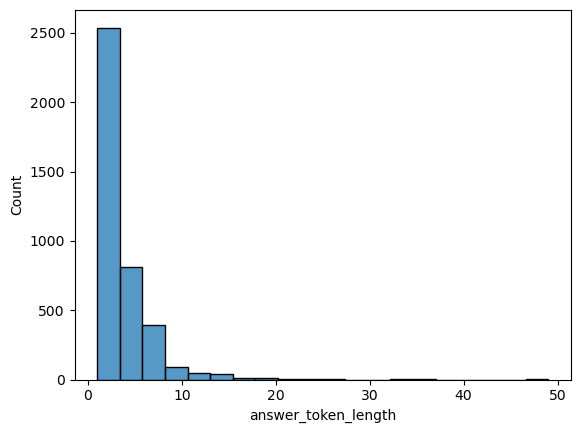

In [61]:
sns.histplot(processed_train_df.answer_token_length, bins = 20)

# Question 확인

In [53]:
processed_train_df.question_length.describe()

count    3952.000000
mean       29.322368
std         8.727421
min         8.000000
25%        23.000000
50%        29.000000
75%        35.000000
max        78.000000
Name: question_length, dtype: float64

<AxesSubplot: xlabel='question_length', ylabel='Count'>

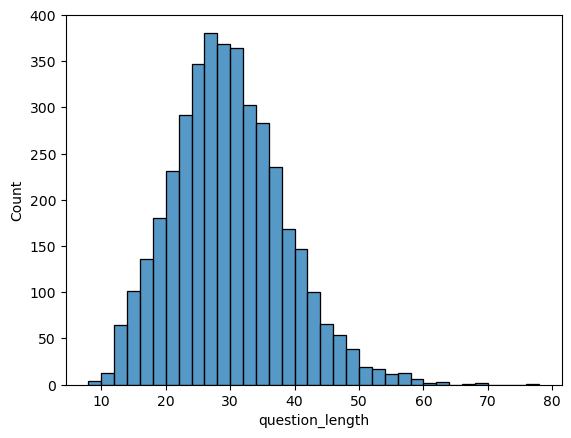

In [54]:
sns.histplot(processed_train_df.question_length, bins=35)

In [55]:
processed_train_df.question_token_length.describe()

count    3952.000000
mean       16.298330
std         4.544425
min         5.000000
25%        13.000000
50%        16.000000
75%        19.000000
max        43.000000
Name: question_token_length, dtype: float64

<AxesSubplot: xlabel='question_token_length', ylabel='Count'>

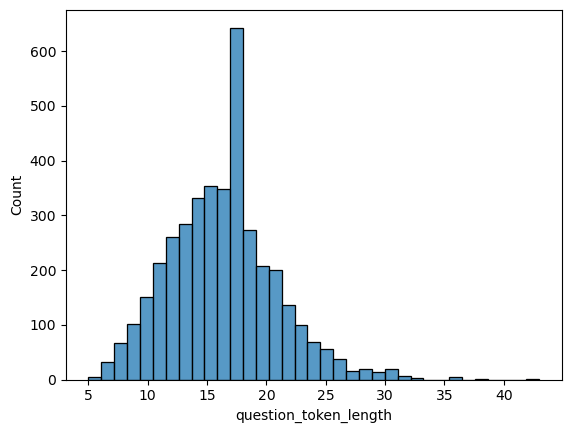

In [56]:
sns.histplot(processed_train_df.question_token_length, bins=35)